# TMD A12B for specific eta

In [142]:
pip install -U pysr

Note: you may need to restart the kernel to use updated packages.


Julia and Julia dependencies are installed at first import:

In [143]:
import pysr

Now, let's import everything else as well as the PySRRegressor:


In [146]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import h5py

# PySR for A12B eta = 8:


In [148]:

file_path = "/Users/hariprashadravikumar/sivers_TMD_PhD_project/save_h5_A12B_A2B/eta_Pb_bsquare_Amp_err_withb0.h5"
#with h5py.File(file_path, "r") as h5_file:
#    # Specify the dataset to extract
#    dataset_name = "Pl-2/eta_8_Pb_bsq_A12B_err"
#    data = np.array(h5_file[dataset_name])

P1 = 1
data_list = []
with h5py.File(file_path, "r") as h5_file:
    dataset_name = f"Pl-{P1}/eta_8_Pb_bsq_A2B_err"
    dataPl = np.array(h5_file[dataset_name])    
    data_list.append(dataPl)

data = np.vstack(data_list)
# Extract bLbT and A12B
PbbsqA2B = data[:, 1:3]  
A2B = data[:, 3]   
A2Berr = data[:, 4]
A2Bweight = [1/sigma**2 for sigma in A2Berr]


#print("bLbT =", bLbT)
#print("A12B =", A12B)
#print("A12Berr =", A12Berr)

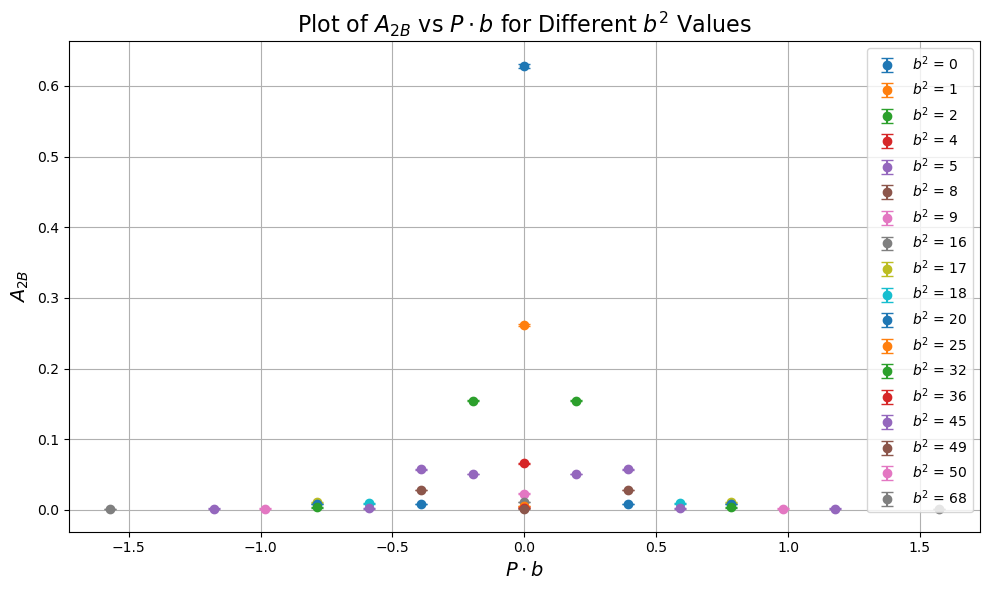

In [152]:

# Extract unique bT values
unique_bsq = np.unique(PbbsqA2B[:, 1])

# Create the plot
plt.figure(figsize=(10, 6))

for i, bsq in enumerate(unique_bsq):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = PbbsqA2B[:, 1] == bsq
    Pb_values = PbbsqA2B[mask, 0]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Pb_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$b^2$ = {int(bsq)}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$P\cdot b$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $P\cdot b$ for Different $b^2$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


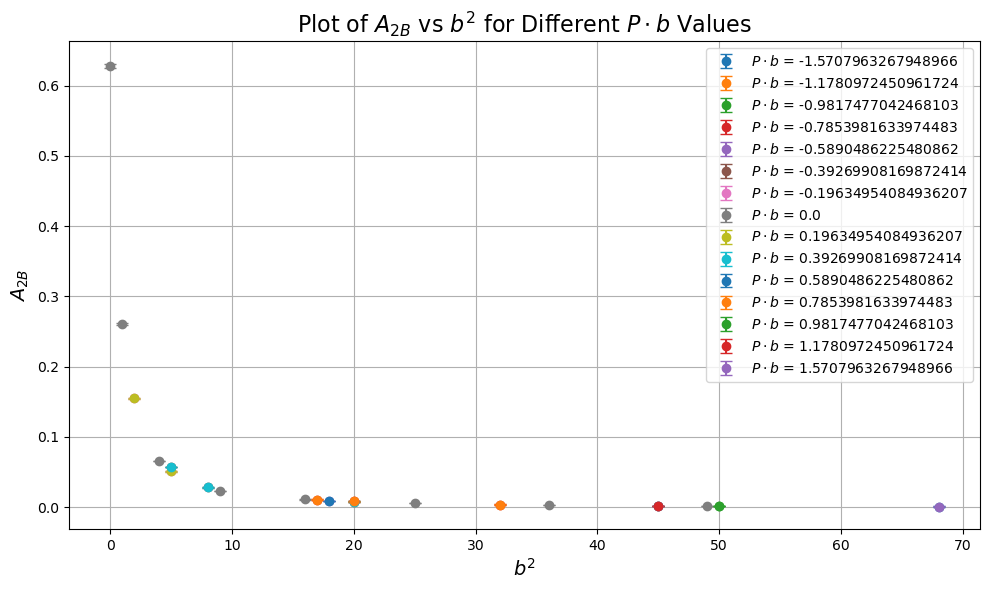

In [154]:
# Extract unique bT values
unique_Pb = np.unique(PbbsqA2B[:, 0])

# Create the plot
plt.figure(figsize=(10, 6))

for i, Pb in enumerate(unique_Pb):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = PbbsqA2B[:, 0] == Pb
    Psq_values = PbbsqA2B[mask, 1]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Psq_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$P\cdot b$ = {Pb}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b^2$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $b^2$ for Different $P\cdot b$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [163]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

In [189]:
from sympy import exp, sech, symbols, Function

custom_loss_function = """
using Symbolics

function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
    prediction, flag = eval_tree_array(tree, dataset.X, options)
    if !flag
        return L(Inf)
    end
    
    wmse = sum(dataset.weights .* (prediction .- dataset.y) .^ 2) / (dataset.n * sum(dataset.weights))
    return wmse
end
"""

extra_sympy_mappings = {
    "Lorentzian": lambda x, y: 1 / (y + x**2),
    "gaussian": lambda x: exp(-x**2),
    "decay": lambda x: exp(-x),
    "sech": lambda x: sech(x)
}

model = PySRRegressor(
    niterations=50,
    unary_operators=["gaussian(x) = exp(-x^2)",  "sech"],
    binary_operators=["*"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    #nested_constraints = { "gaussian": {"gaussian": 0, "sech": 0, "decay": 0},"sech": {"sech": 0, "gaussian": 0, "decay": 0},  "decay": {"sech": 0, "gaussian": 0, "decay": 0}},
    constraints={'gaussian': (-1, 1), 'sech': (-1, 1)}

)

modelold = PySRRegressor(
    niterations=30,
    unary_operators=["sech"],
    binary_operators=["*", "Lorentzian(x, y) = 1/(y + x^2)"],
    extra_sympy_mappings=extra_sympy_mappings,  # Include the custom mappings
    loss_function=custom_loss_function,  # Use the custom loss function
    #nested_constraints = { "sech": {"sech": 0,  "Lorentzian": 0},  "Lorentzian": {"sech": 0, "Lorentzian": 0}},
    constraints={'gaussian': (-1, 1), 'sech': (-1, 1), 'Lorentzian': (-1, 1)}

)


model.fit(PbbsqA2B, A2B, weights=A2Bweight, variable_names=['Pb', 'bsq'])



/opt/homebrew/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.520e+05
Progress: 912 / 1550 total iterations (58.839%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.592e-05  1.594e+01  y = 0.010525
2           1.361e-05  1.565e-01  y = gaussian(bsq)
4           6.548e-06  3.660e-01  y = sech(bsq) * 0.55036
6           2.396e-06  5.026e-01  y = sech(bsq * 0.4441) * 0.25333
11          1.025e-06  1.698e-01  y = sech(gaussian(gaussian(sech(bsq * 0.25512))) * bsq) * ...
                                      0.42506
13          9.951e-07  1.494e-02  y = sech((gaussian(gaussian(sech(bsq * 0.2822))) * bsq) * ...
                                      1.1123) * 0.46749
14          7.154e-07  3.300e-01  y = gaussian(sech(gaussian(bsq))) * sech(gaussian(gaussian...
                                      (sech(bsq *

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.01052533   
	1         0.156468                                      gaussian(bsq)   
	2         0.365953                              sech(bsq) * 0.5503574   
	3         0.502572                sech(bsq * -0.44627348) * 0.2549888   
	4         0.024704  sech(sech(Pb) * (bsq * -0.44985914)) * 0.24618223   
	5         0.387570  sech(gaussian(gaussian(sech(bsq * -0.2577408))...   
	6         0.020200  sech((gaussian(gaussian(sech(bsq * 0.2894965))...   
	7   >>>>  0.319235  gaussian(sech(gaussian(bsq))) * sech(gaussian(...   
	8         0.045714  gaussian(sech(gaussian(bsq * -3.0413811))) * s...   
	9         0.159872  sech((sech(Pb) * gaussian(gaussian(sech(bsq * ...   
	10        0.057757  sech(sech(Pb) * (gaussian(gaussian(sech(0.2599...   
	
	            loss  complexity  
	0   1.591817e-05           1  
	1   1.361256e-05           2  
	2   6.547524e-06           4  
	3   2.396340e-06           6  
	4   2.225166e-06           9  
	5   1.024999e-06          11  
	6   9.844155e-07          13  
	7   7.153792e-07          14  
	8   6.528741e-07          16  
	9   5.564140e-07          17  
	10  4.957135e-07          19  
]

  - outputs/20250317_180928_wnu0ha/hall_of_fame.csv


In [193]:
model.sympy(10)

exp(-sech(exp(-3.23122878433161*bsq**2))**2)*sech(bsq*exp(-exp(-2*sech(0.25998452*bsq)**2))*sech(Pb))

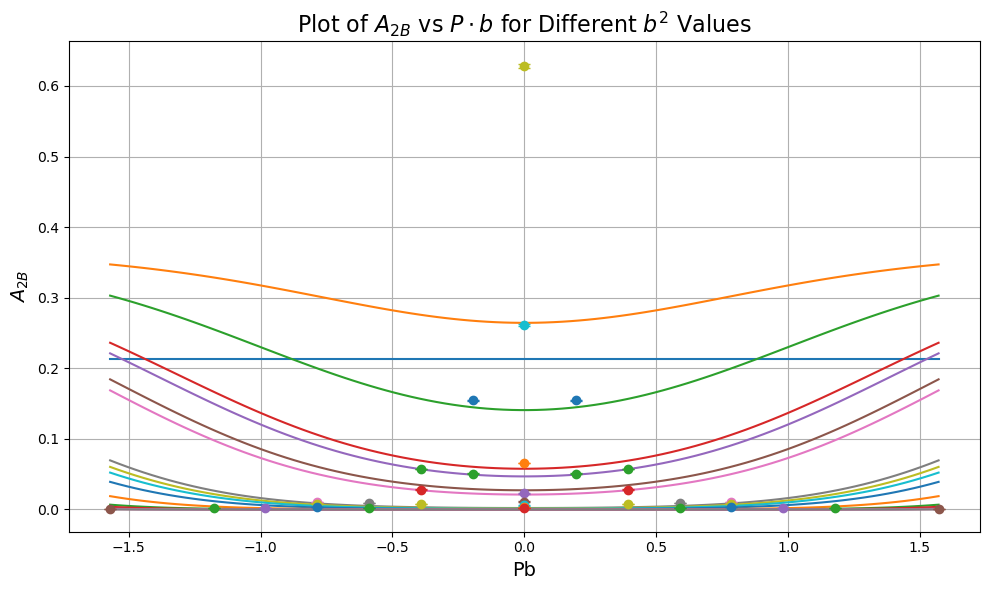

exp(-sech(exp(-3.23122878433161*bsq**2))**2)*sech(bsq*exp(-exp(-2*sech(0.25998452*bsq)**2))*sech(Pb))

In [195]:
pick = 10


Pb_plot = np.linspace(-max(unique_Pb),max(unique_Pb), 100)
plt.figure(figsize=(10, 6))

for bsq in unique_bsq:
    Pbbsq_plot = np.array([[Pb, bsq] for Pb in Pb_plot])
    predictions = model.predict(Pbbsq_plot, pick)
    plt.plot(Pb_plot, predictions)
for i, bsq in enumerate(unique_bsq):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = PbbsqA2B[:, 1] == bsq
    Pb_values = PbbsqA2B[mask, 0]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Pb_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("Pb", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $P\cdot b$ for Different $b^2$ Values", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()



model.sympy(pick)

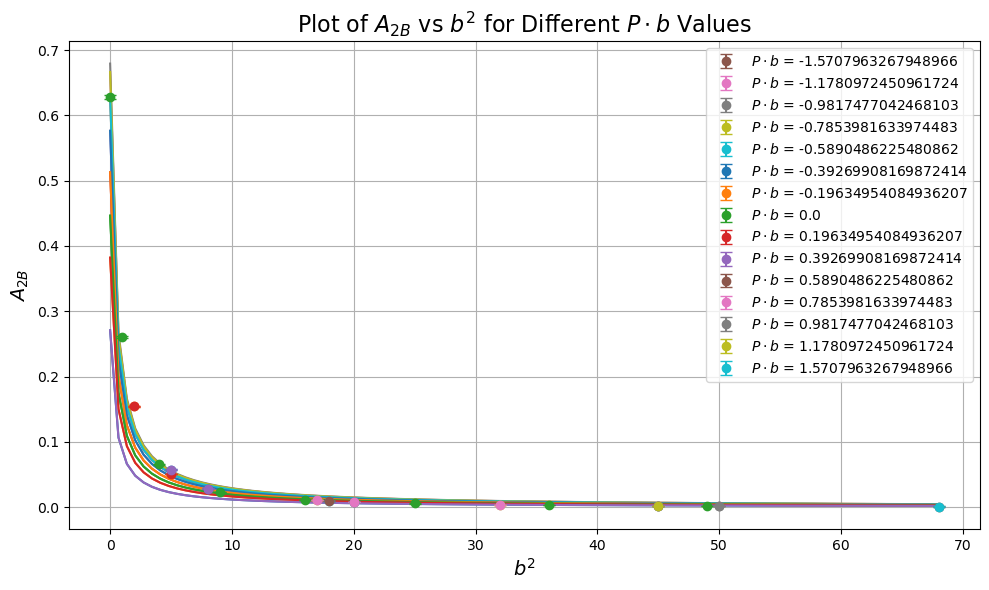

0.30194923*sech(Pb)/(bsq + 0.44438915727504)

In [139]:

b2_plot = np.linspace(0,max(unique_bsq), 100)
plt.figure(figsize=(10, 6))

for Pb in unique_Pb:
    Pbbsq_plott = np.array([[Pb, bsq] for bsq in b2_plot])
    predictions = model.predict(Pbbsq_plott, pick)
    plt.plot(b2_plot, predictions)

for i, Pb in enumerate(unique_Pb):
    #if bT<1 :
    #    continue
    # Filter data for the current bT value
    mask = PbbsqA2B[:, 0] == Pb
    Psq_values = PbbsqA2B[mask, 1]
    A2B_values = A2B[mask]
    A2B_errors = A2Berr[mask]

    # Plot with error bars
    plt.errorbar(
        Psq_values,
        A2B_values,
        yerr=A2B_errors,
        fmt='o',
        label=f"$P\cdot b$ = {Pb}",
        capsize=4
    )
# Add labels, legend, and grid
plt.xlabel("$b^2$", fontsize=14)
plt.ylabel("$A_{2B}$", fontsize=14)
plt.title("Plot of $A_{2B}$ vs $b^2$ for Different $P\cdot b$ Values", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

model.sympy(pick)


In [ ]:
model.equations_[["complexity", "loss", "equation"]]